In [ ]:
%tensorflow_version 1.x
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras.layers.core import SpatialDropout2D
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [ ]:

pre_filelist_trainx = sorted(glob.glob('/content/drive/My Drive/input/pre_train_x/*.png'), key=numericalSort)
pre_X_train = np.array([np.array(Image.open(fname)) for fname in pre_filelist_trainx])

pre_filelist_trainy = sorted(glob.glob('/content/drive/My Drive/input/pre_train_y/*.png'), key=numericalSort)
pre_Y_train = np.array([np.array(Image.open(fname)) for fname in pre_filelist_trainy])

filelist_trainx = sorted(glob.glob('/content/drive/My Drive/input/dgu_trainx/*.jpg'), key=numericalSort)
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('/content/drive/My Drive/input/dgu_trainy_out/*.jpg'), key=numericalSort)
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

print(len(filelist_trainx))
print(len(filelist_trainy))

102
102


In [ ]:
print(X_train[0].shape)
print(Y_train[0].shape)

(700, 1440, 3)
(700, 1440, 3)


In [ ]:
def resizeX(filename, size = (224,224)):
    im = Image.open(filename)
    im_resized = im.resize(size)
    return (im_resized)

def resizeY(filename, size = (224,224)):
    im = Image.open(filename)
    im_resized = im.resize(size).convert('1')
    return (im_resized)

In [ ]:
X_train_ph2_resized = []
Y_train_ph2_resized = []
pre_X_train_ph2_resized = []
pre_Y_train_ph2_resized = []

for i in range(len(filelist_trainx)):
    X_train_ph2_resized.append(resizeX(filelist_trainx[i]))
    Y_train_ph2_resized.append(resizeY(filelist_trainy[i])) 

for i in range(len(pre_filelist_trainx)):
    pre_X_train_ph2_resized.append(resizeX(pre_filelist_trainx[i]))
    pre_Y_train_ph2_resized.append(resizeY(pre_filelist_trainy[i])) 

In [ ]:
del(X_train)
del(Y_train)
del(pre_X_train)
del(pre_Y_train)

X_train = np.array([np.array(img) for img in X_train_ph2_resized])
Y_train = np.array([np.array(img) for img in Y_train_ph2_resized])
pre_X_train = np.array([np.array(img) for img in pre_X_train_ph2_resized])
pre_Y_train = np.array([np.array(img) for img in pre_Y_train_ph2_resized])

(224, 224, 3)
(224, 224)


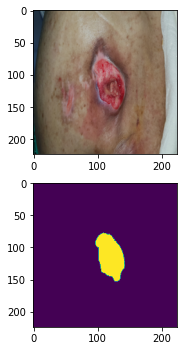

In [ ]:
print(X_train[0].shape)
print(Y_train[0].shape)

plt.figure(figsize=(20,9))
plt.subplot(3,4,1)
plt.imshow(X_train[0])
plt.subplot(3,4,5)
plt.imshow(Y_train[0])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 101)
pre_x_train, pre_x_test, pre_y_train, pre_y_test = train_test_split(pre_X_train, pre_Y_train, test_size = 0.25, random_state = 101)

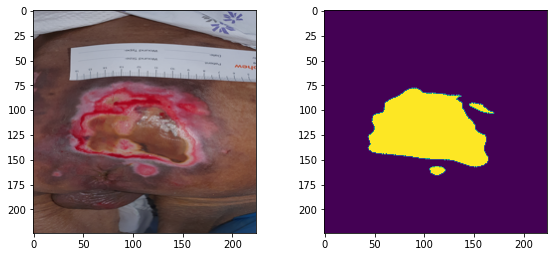

In [ ]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(x_train[1])
plt.subplot(2,4,2)
plt.imshow(y_train[1])
plt.show()

In [ ]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

In [ ]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [ ]:
def dice_coe(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [ ]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [ ]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [ ]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [ ]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)
pre_x_rotated, pre_y_rotated, pre_x_flipped, pre_y_flipped = img_augmentation(pre_x_train, pre_y_train)

In [ ]:
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])
pre_x_train_full = np.concatenate([pre_x_train, pre_x_rotated, pre_x_flipped])
pre_y_train_full = np.concatenate([pre_y_train, pre_y_rotated, pre_y_flipped])

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)
pre_x_train, pre_x_val, pre_y_train, pre_y_val = train_test_split(pre_x_train_full, pre_y_train_full, test_size = 0.20, random_state = 101)

In [ ]:
print(x_train[0].shape)
print(y_train[0].shape)

(224, 224, 3)
(224, 224)


In [ ]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))
print("Length of the pre Training Set   : {}".format(len(pre_x_train)))
print("Length of the pre Test Set       : {}".format(len(pre_x_test)))
print("Length of the pre Validation Set : {}".format(len(pre_x_val)))

Length of the Training Set   : 364
Length of the Test Set       : 26
Length of the Validation Set : 92
Length of the pre Training Set   : 2990
Length of the pre Test Set       : 208
Length of the pre Validation Set : 748


In [ ]:
# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 3
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
# Pretrained weights

In [ ]:
def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
    if K.common.image_dim_ordering() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv


def UNET_224(epochs_num, savename, x_train, y_train, x_val, y_val, learningRate = 0.003):
    dropout_val=0.50
    if K.common.image_dim_ordering() == 'th':
        inputs = Input((INPUT_CHANNELS, 224, 224))
        axis = 1
    else:
        inputs = Input((224, 224, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    pred = Reshape((224,224))(conv_final)
    model = Model(inputs, pred, name="UNET_224")
    model.compile(optimizer= Adam(lr = learningRate), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 3,validation_data=(x_val, y_val), verbose=1)
    model.save(savename)
    return model, hist

In [ ]:
model, hist = UNET_224(1, 'pre_1epoch.h5', pre_x_train, pre_y_train, pre_x_val, pre_y_val)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "UNET_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 32) 0           batch_normalization_1[0][0]      
_________

In [ ]:
dropout_val=0.50
if K.common.image_dim_ordering() == 'th':
    inputs = Input((INPUT_CHANNELS, 224, 224))
    axis = 1
else:
    inputs = Input((224, 224, INPUT_CHANNELS))
    axis = 3
filters = 32

conv_224 = double_conv_layer(inputs, filters)
pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

conv_112 = double_conv_layer(pool_112, 2*filters)
pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

conv_56 = double_conv_layer(pool_56, 4*filters)
pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

conv_28 = double_conv_layer(pool_28, 8*filters)
pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

conv_14 = double_conv_layer(pool_14, 16*filters)
pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

conv_7 = double_conv_layer(pool_7, 32*filters)

up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
up_conv_14 = double_conv_layer(up_14, 16*filters)

up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
up_conv_28 = double_conv_layer(up_28, 8*filters)

up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
up_conv_56 = double_conv_layer(up_56, 4*filters)

up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
up_conv_112 = double_conv_layer(up_112, 2*filters)

up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
conv_final = Activation('sigmoid')(conv_final)
pred = Reshape((224,224))(conv_final)

In [ ]:
model_0 = Model(inputs, pred, name="UNET_224")
model_0.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance], metrics=[iou, dice_coe, precision, recall, accuracy])

In [ ]:
model_0.load_weights('pre_1epoch.h5')

In [ ]:

print('\n~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_0.evaluate(pre_x_train, pre_y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_0.evaluate(pre_x_test, pre_y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}i  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_0.evaluate(pre_x_val, pre_y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

2990/2990 [==============================] - 18s 6ms/step
________________________
IOU:       |   97.53  |
Dice Coef: |   44.76  |
Precision: |   85.60  |
Recall:    |   43.31  |
Accuracy:  |   98.45  |
Loss:      |   2.47  |
________________________

-------------On Test  Set--------------------------

208/208 [==============================] - 2s 8ms/step
________________________
IOU:       |   97.13  |
Dice Coef: |   43.92  |
Precision: |   86.07i  |
Recall:    |   38.40  |
Accuracy:  |   98.01  |
Loss:      |   2.87  |
________________________

-------------On validation Set---------------------

748/748 [==============================] - 4s 6ms/step
________________________
IOU:       |   97.43  |
Dice Coef: |   44.74  |
Precision: |   82.67  |
Recall:    |   44.31  |
Accuracy:  |   98.41  |
Loss:      |   2.57  |
________________________


In [ ]:
model, hist = UNET_224(100, '/content/drive/My Drive/models/pre_100_epoch.h5', pre_x_train, pre_y_train, pre_x_val, pre_y_val)
# model_out, hist_out = UNET_224(100, 'dgu_unet_100_epoch_out.h5', x_train_out, y_train_out, x_val_out, y_val_out)

Model: "UNET_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 224, 224, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 224, 224, 32) 128         conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_47 (Activation)      (None, 224, 224, 32) 0           batch_normalization_45[0][0]     
___________________________________________________________________________________________

In [ ]:
model_1 = Model(inputs, pred, name="UNET_224")
model_1.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])

In [ ]:
model_1.load_weights('/content/drive/My Drive/models/pre_100_epoch.h5')

In [ ]:
print('\n~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_1.evaluate(pre_x_train, pre_y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_1.evaluate(pre_x_test, pre_y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_1.evaluate(pre_x_val, pre_y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

2990/2990 [==============================] - 18s 6ms/step
________________________
IOU:       |   99.68  |
Dice Coef: |   93.28  |
Precision: |   94.54  |
Recall:    |   95.08  |
Accuracy:  |   99.75  |
Loss:      |   0.32  |
________________________

-------------On Test  Set--------------------------

208/208 [==============================] - 1s 6ms/step
________________________
IOU:       |   99.05  |
Dice Coef: |   86.27  |
Precision: |   88.87  |
Recall:    |   86.54  |
Accuracy:  |   99.29  |
Loss:      |   0.95  |
________________________

-------------On validation Set---------------------

748/748 [==============================] - 4s 6ms/step
________________________
IOU:       |   99.50  |
Dice Coef: |   90.81  |
Precision: |   91.39  |
Recall:    |   93.15  |
Accuracy:  |   99.63  |
Loss:      |   0.50  |
________________________


In [ ]:
def enhance(img, filename):
    model_1.load_weights('/content/drive/My Drive/models/' + filename)
    sub = (model_1.predict(img.reshape(1,224,224,3))).flatten()

    # for i in range(len(sub)):
    #     if sub[i] <= 0.165:
    #         sub[i] = 0
    #     elif sub[i] <= 0.97:
    #         sub[i] = 1
    #     else:
    #         sub[i] = 2
    return sub

<Figure size 432x288 with 0 Axes>

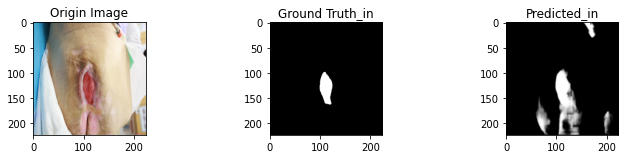

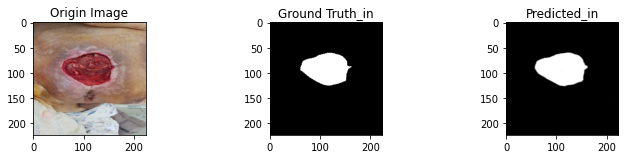

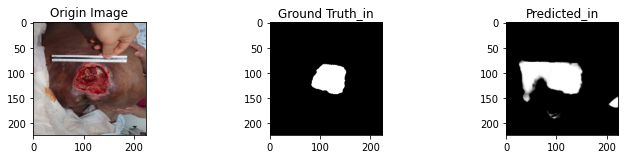

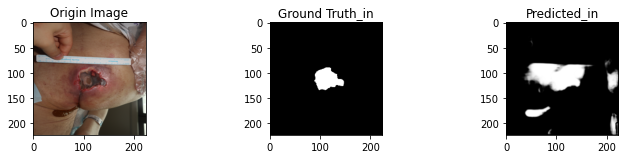

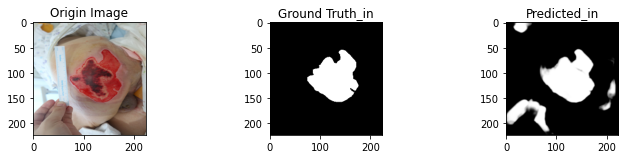

ValueError: ignored

<Figure size 864x864 with 0 Axes>

In [ ]:
plt.suptitle('Comparing the Prediction after enhancement')
for i in range(len(x_test)):
  plt.figure(figsize=(12,12))
  plt.subplot(5,3,1 + i*3)
  plt.title('Origin Image')
  plt.imshow(x_test[i],plt.cm.binary_r)
  plt.subplot(5,3,2 + i*3)
  plt.title('Ground Truth_in')
  plt.imshow(y_test[i],plt.cm.binary_r)
  plt.subplot(5,3,3 + i*3)
  plt.title('Predicted_in')
  plt.imshow(enhance(x_test[i], 'pre_100_epoch.h5').reshape(224,224), plt.cm.binary_r)
  # plt.subplot(5,3,4 + i*3)
  # plt.title('Ground_Truth_out')
  # plt.imshow(y_test_out[i],plt.cm.binary_r)
  # plt.subplot(5,3,5 + i*3)
  # plt.title('Predicted_out')
  # plt.imshow(enhance_out(x_test_out[i]).reshape(224,224),plt.cm.binary_r)
  plt.show()

In [ ]:
for i in range(len(X_train)):
  plt.figure(figsize=(12,4))
  plt.subplot(1,3,1)
  plt.title('Origin Image')
  plt.imshow(X_train[i])
  plt.subplot(1,3,2)
  plt.title('Ground Truth')
  plt.imshow(Y_train[i], plt.cm.binary_r)
  plt.subplot(1,3,3)
  plt.title('Predicted')
  plt.imshow(enhance(X_train[i], 'pre_100_epoch.h5').reshape(224,224), plt.cm.binary_r)
  # plt.subplot(3,2,5)
  # plt.title('Ground_Truth_out')
  # plt.imshow(Y_train_out[i],plt.cm.binary_r)
  # plt.subplot(3,2,6)
  # plt.title('Predicted_out')
  # plt.imshow(enhance_out(X_train[i]).reshape(224,224),plt.cm.binary_r)
  plt.savefig('/content/drive/My Drive/results/total/pre_train/' + str(i) + '.jpg')

  # model_1.load_weights('dgu_unet_100_epoch_in.h5')
  # predictions_in =model_1.predict(x_train_full_in[i].reshape(1,224,224,3))
  # model_1.load_weights('dgu_unet_100_epoch_out.h5')
  # predictions_out = model_1.predict(x_train_full_out[i].reshape(1,224,224,3))
  # prediction_in = predictions_in.reshape(224, 224)
  # prediction_out = predictions_out.reshape(224,224)
  # plt.imsave('/content/drive/My Drive/results/dgu_improved_100epoch_3batch/result_x/' + str(i) + '_x.jpg', x_train_full[i])
  # plt.imsave('/content/drive/My Drive/results/dgu_improved_100epoch_3batch/result_y/' + str(i) + '_y.jpg', y_train_full[i])
  # plt.imsave('/content/drive/My Drive/results/dgu_improved_100epoch_3batch/results/' + str(i) + '.jpg', prediction)

Output hidden; open in https://colab.research.google.com to view.